In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


Bad key text.latex.unicode in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/m

In [2]:
meta_data = pd.read_csv('./Fibroblast_meta.csv', index_col=0)
meta_data = meta_data.sort_index()

sct_normalized_matrix = "./Fibroblast_RNA_scaled.txt"
counts = pd.read_csv(sct_normalized_matrix, sep=',', index_col=0).transpose()
df = counts.sort_index()

In [3]:
top_genes = pd.read_csv('./runx1_targets.csv', index_col=0)

In [4]:
df = df[list(set(top_genes.index).intersection(set(df.columns)))]

In [5]:
df['Recovery'] = meta_data['condition']
df['Recovery'] = [1 if Recovery == "Rpre" else 0 for Recovery in df['Recovery']]

In [6]:
df = df.dropna()

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop('Recovery', axis=1)
y = df['Recovery']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, random_state=42
)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
model = keras.Sequential([
     keras.layers.Flatten(input_shape=(len(df.columns) - 1,)),
     keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.001)),
     layers.Dropout(0.5),
     keras.layers.Dense(16, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.001)),
     layers.Dropout(0.5),
     keras.layers.Dense(1, activation=tf.nn.sigmoid),])

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(from_logits=True)])

model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
7776/7776 [==============================] - 7s 882us/step - loss: 0.7920 - accuracy: 0.7018 - auc: 0.7837
Epoch 2/50
7776/7776 [==============================] - 6s 823us/step - loss: 0.7249 - accuracy: 0.8353 - auc: 0.9092
Epoch 3/50
7776/7776 [==============================] - 6s 796us/step - loss: 0.7060 - accuracy: 0.8618 - auc: 0.9323
Epoch 4/50
7776/7776 [==============================] - 6s 814us/step - loss: 0.6823 - accuracy: 0.8805 - auc: 0.9488
Epoch 5/50
7776/7776 [==============================] - 7s 865us/step - loss: 0.6825 - accuracy: 0.8900 - auc: 0.9527
Epoch 6/50
7776/7776 [==============================] - 6s 792us/step - loss: 0.7056 - accuracy: 0.8835 - auc: 0.9501
Epoch 7/50
7776/7776 [==============================] - 6s 792us/step - loss: 0.6802 - accuracy: 0.8891 - auc: 0.9547
Epoch 8/50
7776/7776 [==============================] - 7s 861us/step - loss: 0.6823 - accuracy: 0.8924 - auc: 0.9546
Epoch 9/50
7776/7776 [==============================] - 

In [11]:
model.evaluate(X_test, y_test)

105/105 [==============================] - 0s 913us/step - loss: 0.7241 - accuracy: 0.8725 - auc: 0.9429


[0.7241125106811523, 0.8724872469902039, 0.9428598880767822]

In [12]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [13]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [14]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

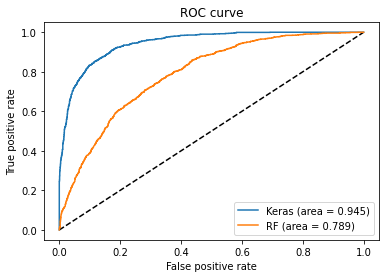

In [15]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()